In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 1
env_name = "SpaceInvaders-v4"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/luke/Documents/RL-Adventure-2/common/multiprocessing_env.py", line 11, in worker
    cmd, data = remote.recv()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


<h2>Neural Network</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class PPO(nn.Module):
    def __init__(self, num_inputs, num_outputs, std=0.0):
        super(PPO, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, stride=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.head = nn.Linear(2112, num_outputs)

        self.apply(init_weights)
        
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.head(x.view(x.size(0), -1)))
        
        std   = self.log_std.exp().expand_as(x)
        dist  = Normal(x, std)
        return dist, x
    


In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=True):
    state = env.reset().transpose((2, 0, 1))

    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = Actor(state)
        action = dist.sample()
        _, action_indx = action.max(1)
        New_state, reward, done, _ = env.step(action_indx.cpu().numpy())
        state = New_state.transpose((2, 0, 1))
        if vis: env.render()
        total_reward += reward
    return total_reward

<h2>GAE</h2>

In [7]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [8]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, _ = Actor(state)
            _, value = Critic(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer_Actor.zero_grad()
            optimizer_Critic.zero_grad()
            loss.backward()
            
            optimizer_Actor.step()
            optimizer_Critic.step()

In [9]:
frame_size= env.observation_space.shape
#num_outputs = envs.action_space.shape[0]
num_inputs  = frame_size[2]
num_outputs = 6

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = 500

Actor = PPO(num_inputs, num_outputs).to(device)
Critic = PPO(num_inputs, 1).to(device)
optimizer_Actor = optim.Adam(Actor.parameters(), lr=lr)
optimizer_Critic = optim.Adam(Critic.parameters(), lr=lr)


In [10]:
max_frames = 15000
frame_idx  = 0
test_rewards = []


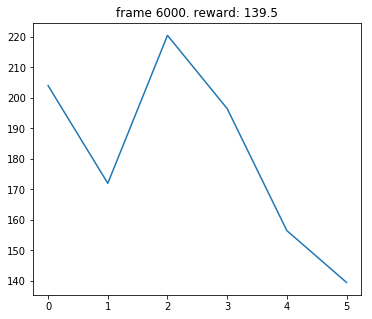

KeyboardInterrupt: 

In [11]:

early_stop = False

while frame_idx < max_frames and not early_stop:
    
    State = envs.reset().transpose((0,3, 1, 2))
    
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        State = torch.FloatTensor(State).to(device)
                
        dist, _ = Actor(State)
        _, value = Critic(State)


        action = dist.sample()
        action_val, action_indx = action.max(1)
        
        next_state, reward, done, _ = envs.step(action_indx.cpu().numpy())
        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(State)
        actions.append(action)
        
        State = next_state.transpose((0,3, 1, 2))
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            
    next_state = torch.FloatTensor(State).to(device)
    
    _, next_value = Critic(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

In [38]:
total_reward = 0 
done = 0
env.reset()
Episodes = 100
for i in range(Episodes):
    done = 0
    env.reset()
    while not done:
        _, reward, done, _ = env.step(env.action_space.sample())
        #env.render()
        total_reward += reward    
print(total_reward/Episodes)

157.15


In [37]:
print(total_reward/100)

144.25


In [16]:
env.step(env.action_space.sample())

AssertionError: Cannot call env.step() before calling reset()